<h1>ACDC Main Demo</h1>

<p>This notebook (which doubles as a script) shows several use cases of ACDC</p>

<p>The codebase is built on top of https://github.com/neelnanda-io/TransformerLens (source version)</p>

<h3>Setup:</h3>
<p>Janky code to do different setup when run in a Colab notebook vs VSCode (adapted from e.g <a href="https://github.com/neelnanda-io/TransformerLens/blob/5c89b7583e73ce96db5e46ef86a14b15f303dde6/demos/Activation_Patching_in_TL_Demo.ipynb">this notebook</a>)</p>

In [1]:
try:
    import google.colab

    IN_COLAB = True
    print("Running as a Colab notebook")

    import subprocess # to install graphviz dependencies
    command = ['apt-get', 'install', 'graphviz-dev']
    subprocess.run(command, check=True)

    import os # make images folder
    os.mkdir("ims/")

    from IPython import get_ipython
    ipython = get_ipython()

    ipython.run_line_magic( # install ACDC
        "pip",
        "install git+https://github.com/ArthurConmy/Automatic-Circuit-Discovery.git@9d5844a",
    )

except Exception as e:
    IN_COLAB = False
    print("Running as a outside of colab")

    import numpy # crucial to not get cursed error
    import plotly

    plotly.io.renderers.default = "colab"  # added by Arthur so running as a .py notebook with #%% generates .ipynb notebooks that display in colab
    # disable this option when developing rather than generating notebook outputs

    import os # make images folder
    if not os.path.exists("ims/"):
        os.mkdir("ims/")

    from IPython import get_ipython

    ipython = get_ipython()
    if ipython is not None:
        print("Running as a notebook")
        ipython.run_line_magic("load_ext", "autoreload")  # type: ignore
        ipython.run_line_magic("autoreload", "2")  # type: ignore
    else:
        print("Running as a script")

Running as a outside of colab
Running as a notebook


<h2>Imports etc</h2>

In [2]:
import wandb
import IPython
from IPython.display import Image, display
import torch
import gc
from tqdm import tqdm
import networkx as nx
import os
import torch
import huggingface_hub
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from tqdm import tqdm
import yaml
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from transformer_lens.hook_points import HookedRootModule, HookPoint
from transformer_lens.HookedTransformer import (
    HookedTransformer,
)
try:
    from acdc.tracr_task.utils import (
        get_all_tracr_things,
        get_tracr_model_input_and_tl_model,
    )
except Exception as e:
    print(f"Could not import `tracr` because {e}; the rest of the file should work but you cannot use the tracr tasks")
from acdc.docstring.utils import get_all_docstring_things
from acdc.acdc_utils import (
    make_nd_dict,
    reset_network,
    shuffle_tensor,
    cleanup,
    ct,
    TorchIndex,
    Edge,
    EdgeType,
)  # these introduce several important classes !!!

from acdc.TLACDCCorrespondence import TLACDCCorrespondence
from acdc.TLACDCInterpNode import TLACDCInterpNode
from acdc.TLACDCExperiment import TLACDCExperiment

from acdc.acdc_utils import (
    kl_divergence,
)
from acdc.ioi.utils import (
    get_all_ioi_things,
    get_gpt2_small,
)
from acdc.induction.utils import (
    get_all_induction_things,
    get_validation_data,
    get_good_induction_candidates,
    get_mask_repeat_candidates,
)
from acdc.greaterthan.utils import get_all_greaterthan_things
from acdc.acdc_graphics import (
    build_colorscheme,
    show,
)
import argparse

torch.autograd.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h2>ACDC Experiment Setup</h2>
<p>We use a `parser to set all the options for the ACDC experiment.
This is still usable in notebooks! We can pass a string to the parser, see below.
We'll reproduce </p>

In [3]:
parser = argparse.ArgumentParser(description="Used to launch ACDC runs. Only task and threshold are required")

task_choices = ['ioi', 'docstring', 'induction', 'tracr-reverse', 'tracr-proportion', 'greaterthan']
parser.add_argument('--task', type=str, required=True, choices=task_choices, help=f'Choose a task from the available options: {task_choices}')
parser.add_argument('--threshold', type=float, required=True, help='Value for THRESHOLD')
parser.add_argument('--first-cache-cpu', type=str, required=False, default="True", help='Value for FIRST_CACHE_CPU (the old name for the `online_cache`)')
parser.add_argument('--second-cache-cpu', type=str, required=False, default="True", help='Value for SECOND_CACHE_CPU (the old name for the `corrupted_cache`)')
parser.add_argument('--zero-ablation', action='store_true', help='Use zero ablation')
parser.add_argument('--using-wandb', action='store_true', help='Use wandb')
parser.add_argument('--wandb-entity-name', type=str, required=False, default="remix_school-of-rock", help='Value for WANDB_ENTITY_NAME')
parser.add_argument('--wandb-group-name', type=str, required=False, default="default", help='Value for WANDB_GROUP_NAME')
parser.add_argument('--wandb-project-name', type=str, required=False, default="acdc", help='Value for WANDB_PROJECT_NAME')
parser.add_argument('--wandb-run-name', type=str, required=False, default=None, help='Value for WANDB_RUN_NAME')
parser.add_argument("--wandb-dir", type=str, default="/tmp/wandb")
parser.add_argument("--wandb-mode", type=str, default="online")
parser.add_argument('--indices-mode', type=str, default="normal")
parser.add_argument('--names-mode', type=str, default="normal")
parser.add_argument('--device', type=str, default="cuda")
parser.add_argument('--reset-network', type=int, default=0, help="Whether to reset the network we're operating on before running interp on it")
parser.add_argument('--metric', type=str, default="kl_div", help="Which metric to use for the experiment")
parser.add_argument('--torch-num-threads', type=int, default=0, help="How many threads to use for torch (0=all)")
parser.add_argument('--seed', type=int, default=1234)
parser.add_argument("--max-num-epochs",type=int, default=100_000)
parser.add_argument('--single-step', action='store_true', help='Use single step, mostly for testing')

if ipython is not None:
    # we are in a notebook
    # you can put the command you would like to run as the ... in r"""..."""
    args = parser.parse_args(
        [line.strip() for line in r"""--task=induction\
--zero-ablation\
--threshold=0.71\
--indices-mode=reverse\
--first-cache-cpu=False\
--second-cache-cpu=False\
--max-num-epochs=100000""".split("\\\n")]
    )
else:
    # read from command line
    args = parser.parse_args()

# process args

if args.torch_num_threads > 0:
    torch.set_num_threads(args.torch_num_threads)
torch.manual_seed(args.seed)

TASK = args.task
if args.first_cache_cpu is None: # manage default
    ONLINE_CACHE_CPU = True
elif args.first_cache_cpu.lower() == "false":
    ONLINE_CACHE_CPU = False
elif args.first_cache_cpu.lower() == "true":
    ONLINE_CACHE_CPU = True
else: 
    raise ValueError(f"first_cache_cpu must be either True or False, got {args.first_cache_cpu}")
if args.second_cache_cpu is None:
    CORRUPTED_CACHE_CPU = True
elif args.second_cache_cpu.lower() == "false":
    CORRUPTED_CACHE_CPU = False
elif args.second_cache_cpu.lower() == "true":
    CORRUPTED_CACHE_CPU = True
else:
    raise ValueError(f"second_cache_cpu must be either True or False, got {args.second_cache_cpu}")
THRESHOLD = args.threshold  # only used if >= 0.0
ZERO_ABLATION = True if args.zero_ablation else False
USING_WANDB = True if args.using_wandb else False
WANDB_ENTITY_NAME = args.wandb_entity_name
WANDB_PROJECT_NAME = args.wandb_project_name
WANDB_RUN_NAME = args.wandb_run_name
WANDB_GROUP_NAME = args.wandb_group_name
INDICES_MODE = args.indices_mode
NAMES_MODE = args.names_mode
DEVICE = args.device
RESET_NETWORK = args.reset_network
SINGLE_STEP = True if args.single_step else False

<h2>Setup Task</h2>

In [4]:
second_metric = None  # some tasks only have one metric
use_pos_embed = TASK.startswith("tracr")

if TASK == "ioi":
    num_examples = 100
    things = get_all_ioi_things(
        num_examples=num_examples, device=DEVICE, metric_name=args.metric
    )
elif TASK == "tracr-reverse":
    num_examples = 6
    things = get_all_tracr_things(
        task="reverse",
        metric_name=args.metric,
        num_examples=num_examples,
        device=DEVICE,
    )
elif TASK == "tracr-proportion":
    num_examples = 50
    things = get_all_tracr_things(
        task="proportion",
        metric_name=args.metric,
        num_examples=num_examples,
        device=DEVICE,
    )
elif TASK == "induction":
    num_examples = 10 if IN_COLAB else 50
    seq_len = 300
    # TODO initialize the `tl_model` with the right model
    things = get_all_induction_things(
        num_examples=num_examples, seq_len=seq_len, device=DEVICE, metric=args.metric
    )
elif TASK == "docstring":
    num_examples = 50
    seq_len = 41
    things = get_all_docstring_things(
        num_examples=num_examples,
        seq_len=seq_len,
        device=DEVICE,
        metric_name=args.metric,
        correct_incorrect_wandb=True,
    )
elif TASK == "greaterthan":
    num_examples = 100
    things = get_all_greaterthan_things(
        num_examples=num_examples, metric_name=args.metric, device=DEVICE
    )
else:
    raise ValueError(f"Unknown task {TASK}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model redwood_attn_2l into HookedTransformer


<p> Let's define the four most important objects for ACDC experiments:

In [5]:
validation_metric = things.validation_metric # metric we use (e.g KL divergence)
toks_int_values = things.validation_data # clean data x_i
toks_int_values_other = things.validation_patch_data # corrupted data x_i'
tl_model = things.tl_model # transformerlens model

if RESET_NETWORK:
    reset_network(TASK, DEVICE, tl_model)

<h2>Setup ACDC Experiment</h2>

In [9]:
# Make notes for potential wandb run
try:
    with open(__file__, "r") as f:
        notes = f.read()
except:
    notes = "No notes generated, expected when running in an .ipynb file"

tl_model.reset_hooks()

# Save some mem
gc.collect()
torch.cuda.empty_cache()

# Setup wandb if needed
if WANDB_RUN_NAME is None or IPython.get_ipython() is not None:
    WANDB_RUN_NAME = f"{ct()}{'_randomindices' if INDICES_MODE=='random' else ''}_{THRESHOLD}{'_zero' if ZERO_ABLATION else ''}"
else:
    assert WANDB_RUN_NAME is not None, "I want named runs, always"

tl_model.reset_hooks()
exp = TLACDCExperiment(
    model=tl_model,
    threshold=THRESHOLD,
    using_wandb=USING_WANDB,
    wandb_entity_name=WANDB_ENTITY_NAME,
    wandb_project_name=WANDB_PROJECT_NAME,
    wandb_run_name=WANDB_RUN_NAME,
    wandb_group_name=WANDB_GROUP_NAME,
    wandb_notes=notes,
    wandb_dir=args.wandb_dir,
    wandb_mode=args.wandb_mode,
    wandb_config=args,
    zero_ablation=ZERO_ABLATION,
    ds=toks_int_values,
    ref_ds=toks_int_values_other,
    metric=validation_metric,
    second_metric=second_metric,
    verbose=True,
    indices_mode=INDICES_MODE,
    names_mode=NAMES_MODE,
    corrupted_cache_cpu=CORRUPTED_CACHE_CPU,
    hook_verbose=False,
    online_cache_cpu=ONLINE_CACHE_CPU,
    add_sender_hooks=True,
    use_pos_embed=use_pos_embed,
    add_receiver_hooks=False,
    remove_redundant=False,
    show_full_index=use_pos_embed,
)

dict_keys(['blocks.1.hook_resid_post', 'blocks.1.attn.hook_result', 'blocks.1.attn.hook_q', 'blocks.1.hook_q_input', 'blocks.1.attn.hook_k', 'blocks.1.hook_k_input', 'blocks.1.attn.hook_v', 'blocks.1.hook_v_input', 'blocks.0.attn.hook_result', 'blocks.0.attn.hook_q', 'blocks.0.hook_q_input', 'blocks.0.attn.hook_k', 'blocks.0.hook_k_input', 'blocks.0.attn.hook_v', 'blocks.0.hook_v_input', 'blocks.0.hook_resid_pre'])
ln_final.hook_normalized
ln_final.hook_scale
blocks.1.hook_resid_post
blocks.1.hook_attn_out
blocks.1.attn.hook_result
blocks.1.attn.hook_z
blocks.1.attn.hook_pattern
blocks.1.attn.hook_attn_scores
blocks.1.attn.hook_v
blocks.1.attn.hook_k
blocks.1.attn.hook_q
blocks.1.ln1.hook_normalized
blocks.1.ln1.hook_scale
blocks.1.hook_v_input
blocks.1.hook_k_input
blocks.1.hook_q_input
blocks.1.hook_resid_pre
blocks.0.hook_resid_post
blocks.0.hook_attn_out
blocks.0.attn.hook_result
blocks.0.attn.hook_z
blocks.0.attn.hook_pattern
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_v
blo

<h2>Run steps of ACDC: iterate over a NODE in the model's computational graph</h2>
<p>WARNING! This will take a few minutes to run, but there should be rolling nice pictures too : )</p>

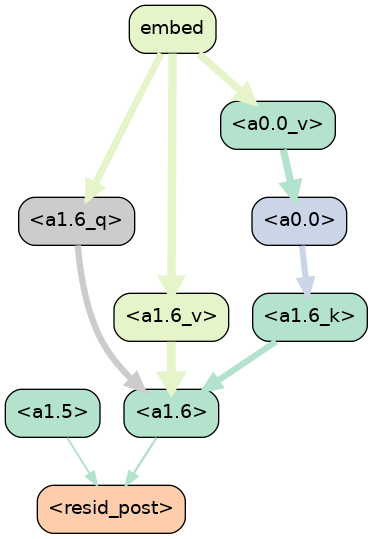

0 --------------------------------------------------
No edge 10
10


In [8]:
for i in range(args.max_num_epochs):
    exp.step(testing=False)

    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=use_pos_embed,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))

    print(i, "-" * 50)
    print(exp.count_no_edges())

    if i == 0:
        exp.save_edges("edges.pkl")

    if exp.current_node is None or SINGLE_STEP:
        break

exp.save_edges("another_final_edges.pkl")

if USING_WANDB:
    edges_fname = f"edges.pth"
    exp.save_edges(edges_fname)
    artifact = wandb.Artifact(edges_fname, type="dataset")
    artifact.add_file(edges_fname)
    wandb.log_artifact(artifact)
    os.remove(edges_fname)
    wandb.finish()

<h2>Save the final subgraph of the model</h2>
<p>There are more than `exp.count_no_edges()` here because we include some "placeholder" edges needed to make ACDC work that only matter internally (they don't help vizualization)</p>
<p>We recover minimal induction machinery! `embed -> a0.0_v -> a1.6k`</p>

In [ ]:
exp.save_subgraph(
    return_it=True,
) 

OrderedDict([(('blocks.1.hook_resid_post',
               (None,),
               'blocks.1.attn.hook_result',
               (None, None, 6)),
              True),
             (('blocks.1.hook_resid_post',
               (None,),
               'blocks.1.attn.hook_result',
               (None, None, 5)),
              True),
             (('blocks.1.hook_resid_post',
               (None,),
               'blocks.0.hook_resid_pre',
               (None,)),
              True),
             (('blocks.1.attn.hook_result',
               (None, None, 6),
               'blocks.1.attn.hook_q',
               (None, None, 6)),
              True),
             (('blocks.1.attn.hook_result',
               (None, None, 6),
               'blocks.1.attn.hook_k',
               (None, None, 6)),
              True),
             (('blocks.1.attn.hook_result',
               (None, None, 6),
               'blocks.1.attn.hook_v',
               (None, None, 6)),
              True),
        